In [5]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pytz
import yfinance as yf

In [7]:
tolerance = 0.
look_back = 12
h = 2

rule = 'BME'

list_choice = 'technology'

time_range = '5y'

start_time = '2019-12-31'
end_time = '2024-01-01'

# Vol scaling
vol_flag = 0                  # Set flag to 1 for vol targeting
if vol_flag == 1:
    target_vol = 0.4 # Can be changed
else:
    target_vol = 'no target vol'


In [8]:
def US_Stock_data():
    tickers = pd.read_html( 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

    stock_list = tickers['Symbol'].to_list()
    futures = pd.DataFrame(columns= stock_list)

    time_index = list(yf.Ticker(stock_list[0]).history(period = time_range,start = start_time, end = end_time).index)
    flag = 0

    for symbol in stock_list:
        df = yf.Ticker(symbol).history(period = time_range, start = start_time, end = end_time)
        df = pd.DataFrame(df['Close'])
        i = 0
        daily_return = []
        for k in df['Close']:
            if i != 0:
                daily_return.append(float((k-i)/i))
            else:
                daily_return.append(float(0))
            i = k
        if time_index != list(df.index): flag +=1
        try:
            futures[symbol] = daily_return
        except:
            print(symbol)
            print(len(daily_return)) # Check differnet time index
            while len(daily_return) < len(futures):
                daily_return.insert(0,float(0))
            futures[symbol] = daily_return

    futures.index = time_index
    futures = futures.iloc[1:, :]


    # print(flag) # Check differnet time index

    return futures

In [9]:
futures = US_Stock_data()

ABNB
768


$AMTM: possibly delisted; no price data found  (1d 2019-12-31 -> 2024-01-01) (Yahoo error = "Data doesn't exist for startDate = 1577768400, endDate = 1704085200")


AMTM
0


$BRK.B: possibly delisted; no timezone found


BRK.B
0


$BF.B: possibly delisted; no price data found  (1d 2019-12-31 -> 2024-01-01)


BF.B
0
CARR
953
CEG
490


GEHC: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']


GEHC
0


$GEV: possibly delisted; no price data found  (1d 2019-12-31 -> 2024-01-01) (Yahoo error = "Data doesn't exist for startDate = 1577768400, endDate = 1704085200")


GEV
0


KVUE: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']


KVUE
0
OTIS
953
PLTR
818


$SW: possibly delisted; no price data found  (1d 2019-12-31 -> 2024-01-01) (Yahoo error = "Data doesn't exist for startDate = 1577768400, endDate = 1704085200")


SW
0


$SOLV: possibly delisted; no price data found  (1d 2019-12-31 -> 2024-01-01) (Yahoo error = "Data doesn't exist for startDate = 1577768400, endDate = 1704085200")


SOLV
0


VLTO: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']


VLTO
0


In [11]:
res = futures
res['Date'] = pd.to_datetime(res.index, format='%Y-%m-%d')
res.set_index('Date', inplace=True)

C:\Users\hungl\AppData\Local\Temp\ipykernel_18260\1076014402.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res['Date'] = pd.to_datetime(res.index, format='%Y-%m-%d')


In [12]:
company = res.columns


In [13]:
def Volatility_scale(res):

    std_index = res.index

    daily_index = pd.DataFrame(index=std_index)

    for oo in res.columns:
        returns = res[oo]
        returns.dropna(inplace=True)
    
        first_date = returns.index[0].strftime("%Y-%m-%d")   # store this to show when data series starts
    
        ret_index = (1 + returns).cumprod()
        ret_index[0] = 1
    
        # equation (1) ex ante vol estimate
        day_vol = returns.ewm(ignore_na=False,
                          adjust=True,
                          com=60,   
                          min_periods=0).std(bias=False)
        vol = day_vol * np.sqrt(261) # annualise
    
        ret_index = pd.concat([ret_index, vol], axis=1)
        ret_index.columns = [oo, oo + '_Vol']

        daily_index = pd.concat([daily_index, ret_index], axis=1)

    return daily_index

In [14]:
def backtest_strategy(k = look_back, h = h):

    pnl = pd.DataFrame(index=res.index)
    leverage = pd.DataFrame(index=res.index)
    strategy_cumm_rtns = pd.DataFrame(index=res.index)


    daily_index = Volatility_scale(res)

    for oo in company:
        df = pd.concat([daily_index[oo], daily_index[oo+"_Vol"]], axis=1)
        df['returns'] = df[oo].pct_change(look_back)
    
        df['pnl'] = 0.
        df['leverage'] = 0.
        try:
            for k, v in enumerate(df['returns']):
                if k <= look_back:
                # skip the first look back observations
                    continue
                if df['returns'].iloc[k-h] < tolerance:
                # negative returns, sell and hold for h day, then close position
                    if vol_flag == 1:
                        df['pnl'].iloc[k] = (df[oo].iloc[k - h] / df[oo].iloc[k] - 1) * \
                                        target_vol / df[oo+"_Vol"].iloc[k - h]
                        df['leverage'].iloc[k] = target_vol / df[oo+"_Vol"].iloc[k - h]
                    else:
                        df['pnl'].iloc[k] = (df[oo].iloc[k - h] / df[oo].iloc[k] - 1)                   
                        df['leverage'].iloc[k] = 1.
                elif df['returns'].iloc[k-1] > tolerance:
                # positive returns, buy and hold for h day, then close position
                    if vol_flag == 1:
                        df['pnl'].iloc[k] = (df[oo].iloc[k] / df[oo].iloc[k - h] - 1) * \
                                        target_vol / df[oo+"_Vol"].iloc[k - h]
                        df['leverage'].iloc[k] = target_vol / df[oo+"_Vol"].iloc[k - h]
                    else:
                        df['pnl'].iloc[k] = (df[oo].iloc[k] / df[oo].iloc[k - h] - 1) 
                        df['leverage'].iloc[k] = 1.
                df = df[:-1]
        except: pass    
        # convert to cummulative index
        pnl = pd.concat([pnl, df['pnl']], axis=1)
        leverage = pd.concat([leverage, df['leverage']], axis=1)
    
        ret_index = (1 + df['pnl'][13:]).cumprod()
        ret_index[0] = 1
        strategy_cumm_rtns = pd.concat([strategy_cumm_rtns, ret_index], axis=1) 


    pnl.columns = res.columns
    leverage.columns = leverage.columns
    strategy_cumm_rtns.columns = res.columns
    df = pnl
    df['port_avg'] = df.mean(skipna = False, axis=1)

    Strategy = df['port_avg'].copy()
    Strategy.name = "TSMOM with Vol"
    dataport_index = (1 + df['port_avg']).cumprod()

    return dataport_index

In [ ]:
plt.plot(backtest_strategy())

In [15]:
df['port_avg']

NameError: name 'df' is not defined

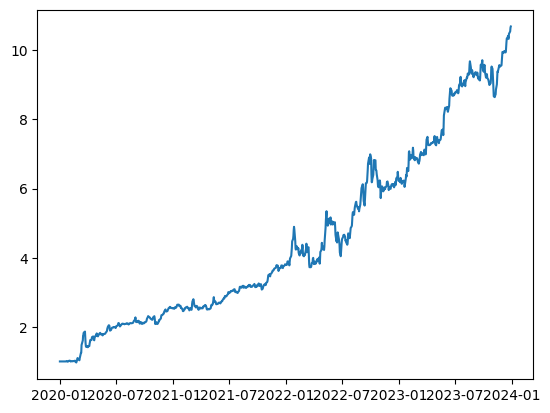

In [ ]:
plt.plot(dataport_index)

In [ ]:
dataport_index

Date
2020-01-02 00:00:00-05:00     1.000000
2020-01-03 00:00:00-05:00     1.000000
2020-01-06 00:00:00-05:00     1.000000
2020-01-07 00:00:00-05:00     1.000000
2020-01-08 00:00:00-05:00     1.000000
                               ...    
2023-12-22 00:00:00-05:00    10.472737
2023-12-26 00:00:00-05:00    10.544459
2023-12-27 00:00:00-05:00    10.651682
2023-12-28 00:00:00-05:00    10.686472
2023-12-29 00:00:00-05:00          NaN
Name: port_avg, Length: 1006, dtype: float64

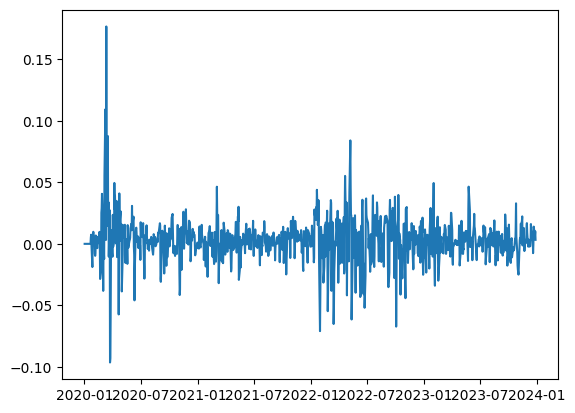

In [ ]:
plt.plot(df['port_avg'])

In [ ]:
dataport_index

Date
2020-01-02 00:00:00-05:00     1.000000
2020-01-03 00:00:00-05:00     1.000000
2020-01-06 00:00:00-05:00     1.000000
2020-01-07 00:00:00-05:00     1.000000
2020-01-08 00:00:00-05:00     1.000000
                               ...    
2023-12-22 00:00:00-05:00    10.472737
2023-12-26 00:00:00-05:00    10.544459
2023-12-27 00:00:00-05:00    10.651682
2023-12-28 00:00:00-05:00    10.686472
2023-12-29 00:00:00-05:00          NaN
Name: port_avg, Length: 1006, dtype: float64

In [ ]:
# print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(df['port_avg'], period='monthly'))
# print ("Annualized Mean Returns = ", empyrical.annual_return(df['port_avg'], period='monthly'))
# print ("Annualized Standard Deviations = ", empyrical.annual_volatility(df['port_avg'], period='monthly'))

In [ ]:
# print("Max Drawdown = ", empyrical.max_drawdown(df['port_avg']))
# print("Calmar ratio = ", empyrical.calmar_ratio(df['port_avg'], period='monthly'))